# Import Packages

In [27]:
"""
Main File for QRT - Electricity Price - 2023 Project
"""
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

from scipy.stats import spearmanr

from xgboost import XGBRegressor
from xgboost import plot_importance


# Data Preprocessing

In [14]:
# Importing Data From Files
curr_dir = '/Users/talhajamal/Desktop/Code/Python_Projects/QRT - 2023 - Electricity Price/'
os.chdir(curr_dir)

X = pd.read_csv(f"{curr_dir}data/X_train_NHkHMNU.csv").set_index('ID').sort_index()
y = pd.read_csv(f"{curr_dir}data/y_train_ZAN5mwg.csv").set_index('ID').sort_index()
x_validation = pd.read_csv(f"{curr_dir}data/X_test_final.csv").set_index('ID')

# Useful Functions

In [36]:
def plot_ts(ts: pd.Series, title: str = None, figsize=(13,5)) -> None:
    """plots a given timeseries and displays an optional title"""
    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    plt.plot(ts)
    plt.title(title or '', fontsize=10)
    plt.grid(alpha=0.5, linestyle='dashed')
    plt.show()

def metric_train(output, Y_clean):
    return  spearmanr(output, Y_clean).correlation

# Missing Data

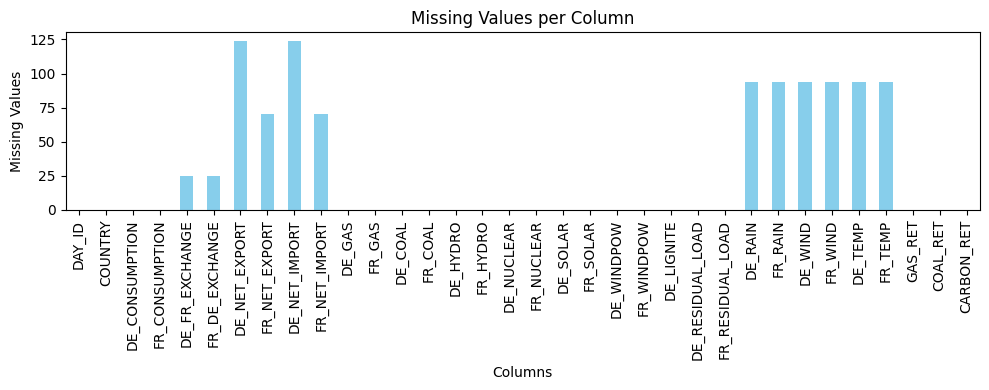

In [16]:
missing_values = X.isna().sum()
missing_values.plot(kind='bar', figsize=(10, 4), color='skyblue')
plt.title('Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Missing Values')
plt.xticks(rotation=90)  # Rotate the x labels to show them vertically
plt.tight_layout()  # Adjust layout to make room for the x labels
plt.show()

# Fill Data

In [17]:
# Fill Missing Data
X = X.interpolate(method='polynomial', order=2)

# Combined Training and Testing Data
#full_data = pd.concat([x_train, x_test], axis=0).sort_index()
#de_full_data = full_data[full_data['COUNTRY'] == 'DE']
#fr_full_data = full_data[full_data['COUNTRY'] == 'FR']

#x_train = x_train.interpolate(method='linear')
#x_test = x_test.interpolate(method='linear')

# Separating data for each country
#de_x_train = x_train[x_train['COUNTRY'] == 'DE']
#de_y_train = y_train[y_train.index.isin(de_x_train.index)]
#fr_x_train = x_train[x_train['COUNTRY'] == 'FR']
#fr_y_train = y_train[y_train.index.isin(fr_x_train.index)]

# XGBoost Regression

In [42]:
# Find best XGB parameters
# Split the training dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.drop(['COUNTRY'], axis=1), y, test_size=0.33, random_state=42)
xg_reg = XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                          max_depth=5, alpha=10, n_estimators=10)
# Fit the regressor to the training set
xg_reg.fit(X_train, y_train)
y_pred = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

RMSE: 0.831071


In [46]:
# Compare Correlation of the best XGB model and the XGB model on the whole training set
X_clean = X.drop(['COUNTRY'], axis=1)
Y_clean = y['TARGET']
xgb = XGBRegressor()
xgb.fit(X_clean, Y_clean)
output_train = xgb.predict(X_clean)
new_output = xg_reg.predict(X_clean)

print('Spearman correlation for the train set: {:.1f}%'.format(100 * metric_train(output_train, Y_clean) ))
print('New Model Spearman correlation for the train set: {:.1f}%'.format(100 * metric_train(new_output, Y_clean) ))

Spearman correlation for the train set: 72.6%
New Model Spearman correlation for the train set: 39.0%


In [44]:
X_validation_clean = x_validation.drop(['COUNTRY'], axis=1).fillna(0)

Y_test_submission = pd.DataFrame()
Y_test_submission['ID'] = x_validation.index.to_list()
Y_test_submission['TARGET'] = xgb.predict(X_validation_clean)

Y_test_submission.to_csv('src/xgb_predictions.csv', index=False)

In [45]:
Y_test_submission

,ID,TARGET
0,1115,-0.272144
1,1202,-0.096273
2,1194,-0.184181
3,1084,0.015469
4,1135,-0.258083
...,...,...
649,879,-0.808060
650,673,0.276241
651,1641,1.822636
652,712,-0.230851


Current out of sample performance is 18.58%. This beats the benchmark Linear Regression Model's performance of 15.9%

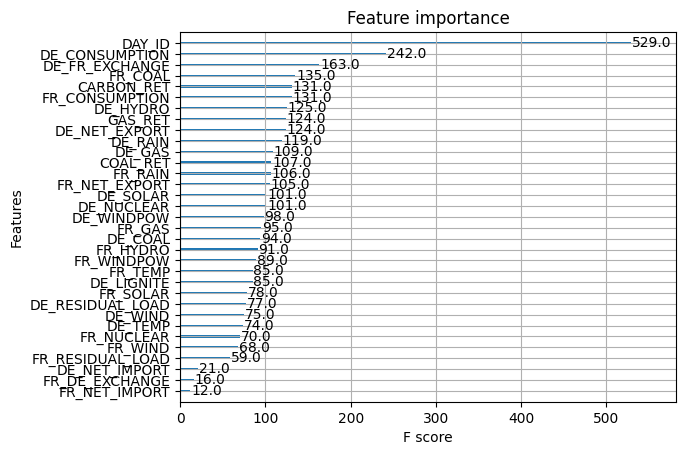

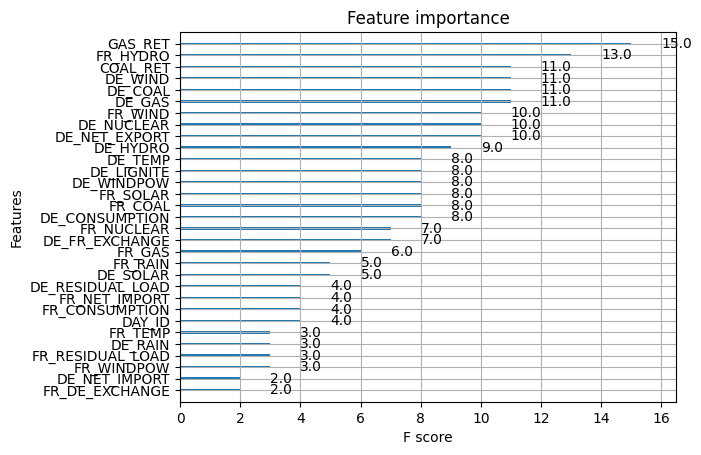

In [30]:
# Feature importance
base_model_feature_importance = xgb.feature_importances_
new_model_feature_importance = xg_reg.feature_importances_

# Plot feature importance
plot_importance(xgb)
plot_importance(xg_reg)
plt.show()

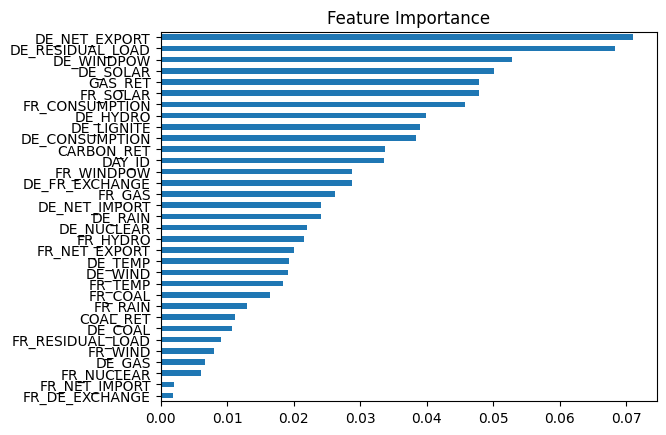

In [33]:


# Perform permutation importance
results = permutation_importance(xgb, X_train, y_train, n_repeats=10, random_state=42)

# Get importance scores
importance_scores = results.importances_mean

# Organize and plot the importance scores
importances = pd.Series(importance_scores, index=X_train.columns)
importances = importances.sort_values()

importances.plot(kind='barh')
plt.title('Feature Importance')
plt.show()

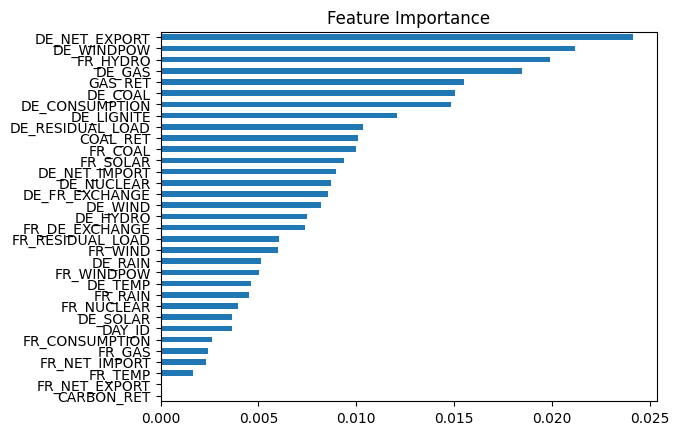

In [34]:
# Perform permutation importance
results = permutation_importance(xg_reg, X_train, y_train, n_repeats=10, random_state=42)

# Get importance scores
importance_scores = results.importances_mean

# Organize and plot the importance scores
importances = pd.Series(importance_scores, index=X_train.columns)
importances = importances.sort_values()

importances.plot(kind='barh')
plt.title('Feature Importance')
plt.show()